# Sales Projection R Analysis by Washim Ahmed
## Including related libraries

In [3]:
.libPaths("/home/rstudio/R/x86_64-pc-linux-gnu-library/3.4")
library(readr)
library(mlbench)
library(e1071)
library(corrplot)
library(caret)
library(mice)
library(VIM)
library(randomForest)
library(glmnet)
library(kernlab)
library(rpart)
library(klaR)
library(nnet)
library(randomForest)

In [48]:
options(repr.plot.width=7, repr.plot.height=5)

## Importing CSV data

In [4]:
DB_F <- read_csv("DB_F.csv", 
                 col_types = cols(s_num = col_skip(), sku_num = col_skip(), promo_exp = col_number(), store_num = col_skip(),
                                  region = col_number(), sales = col_number(), 
                                  sku_face_perc = col_number(), sku_imp = col_number(), 
                                  sku_price = col_number(), sku_stock = col_number(), 
                                  sku_weight = col_number(), store_year = col_number(), 
                                  year_opr = col_number()), na = "NA")

In [11]:
head(DB_F)

sales,sku_weight,sku_energy,sku_position,sku_face_perc,sku_catgr,sku_price,store_year,year_opr,store_size,store_tier,store_type,region,sku_imp,sku_stock,promo_type,promo_exp
995.3710,11.350,High Energy,front,0.0431,fruits and vegetables,197.9742,1987,22,High,Tier 3,Supermarket,1,4,420,hoardings,50.59
535.3032,20.600,High Energy,front,0.0460,snack foods,177.0344,1987,22,High,Tier 3,Supermarket,1,1,361,hoardings,50.59
2025.3636,17.600,High Energy,back,0.0764,meat,113.2202,2009,1,Medium,Tier 3,Minimarket,2,2,226,hoardings,39.95
1414.1592,9.395,Normal,front,0.1037,snack foods,233.6932,1987,22,High,Tier 3,Supermarket,1,2,425,hoardings,50.59
3797.7232,12.150,normal_energy,back,0.0218,breads,164.6184,2002,7,,Tier 2,Supermarket,3,5,551,hoardings,48.66
3338.9870,14.150,normal_energy,front,NA,household,196.3110,1997,12,Small,Tier 1,Supermarket,4,5,526,hoardings,48.38


## Converting categorical variables into factors

In [12]:
DB_F$sku_energy <- as.factor(DB_F$sku_energy)
DB_F$sku_position <- as.factor(DB_F$sku_position)
DB_F$sku_catgr <- as.factor(DB_F$sku_catgr)
DB_F$store_size <- sapply(DB_F$store_size, function(x) gsub("^$|^ $", NA, x)) # Replace emapty values with NA
DB_F$store_size <- as.factor(DB_F$store_size)
DB_F$store_tier <- as.factor(DB_F$store_tier)
DB_F$store_type <- as.factor(DB_F$store_type)
DB_F$promo_type <- as.factor(DB_F$promo_type)

## Descriptive Statistics

In [70]:
summary(DB_F)

     sales            sku_weight             sku_energy     sku_position 
 Min.   :   28.29   Min.   : 4.555   high_energy  : 970   back    :4571  
 1st Qu.:  854.37   1st Qu.: 8.695   High Energy  :4058   far back:1850  
 Median : 1720.21   Median :12.500   Normal       :5974   front   :4575  
 Mean   : 2142.68   Mean   :12.792   normal_energy:3124   middle  :3130  
 3rd Qu.: 3010.24   3rd Qu.:16.750                                       
 Max.   :13086.97   Max.   :21.350                                       
                    NA's   :2256                                         
 sku_face_perc                     sku_catgr      sku_price        store_year  
 Min.   :-0.0045   fruits and vegetables:2045   Min.   : 31.29   Min.   :1984  
 1st Qu.: 0.0320   snack foods          :1965   1st Qu.: 91.72   1st Qu.:1988  
 Median : 0.0584   household            :1507   Median :141.15   Median :1999  
 Mean   : 0.0711   frozen foods         :1438   Mean   :139.48   Mean   :1998  
 3rd Qu.

## Corelation Plot
Sales, SKU price, SKU important, SKU stock, promo expression are highly correlated with each other. We may need to remove this correlated attributes in recursive feature elimination for machine learning model building which covered below in model building sections.

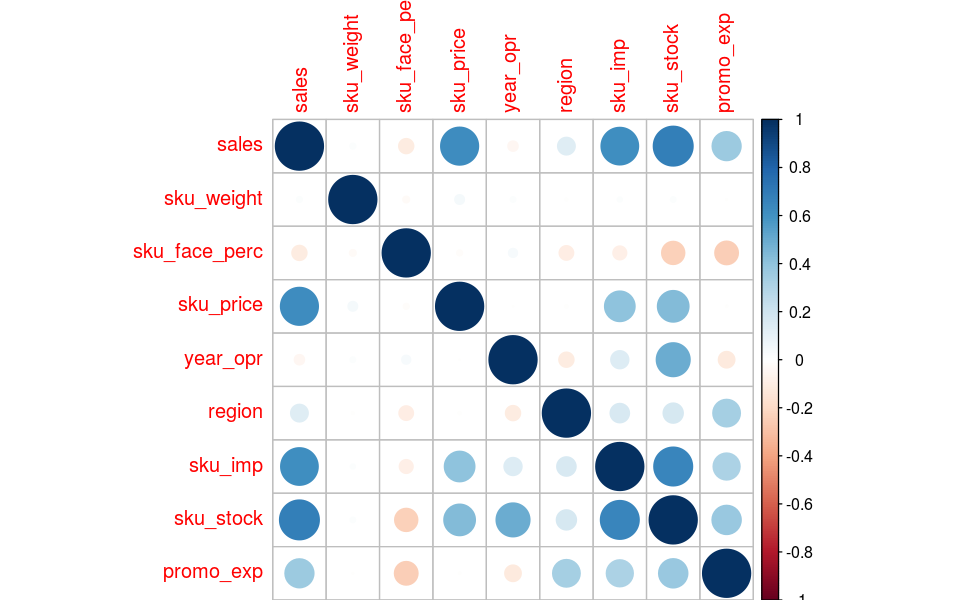

In [40]:
corrplot(cor(na.omit(DB_F[,c('sales','sku_weight','sku_face_perc','sku_price',
                     'year_opr','region','sku_imp','sku_stock','promo_exp')])), method="circle")

# Statistical HypothesisTesting

### One Sample t-Test for Sales
The output of the P-Value in above is > 0.05 which means it accept null hypothesis therefore sales is purely normal distributions with P-Value 1

In [15]:
t.test(DB_F$sales, mu = mean(DB_F$sales))


	One Sample t-test

data:  DB_F$sales
t = 0, df = 14125, p-value = 1
alternative hypothesis: true mean is not equal to 2142.676
95 percent confidence interval:
 2114.942 2170.410
sample estimates:
mean of x 
 2142.676 


### Two Sample t-Test for Sales in different SKU Energy
The output of the p-value < 2.2e-16 which means it rejects null hypothesis therefore we can say sales figure for different SKU energy are statistically different.

In [16]:
sales_high_energy <- DB_F[DB_F$sku_energy=='High Energy',c('sales')]
sales_normal_energy <- DB_F[DB_F$sku_energy=='Normal',c('sales')]
t.test(sales_high_energy$sales, sales_normal_energy$sales)


	Welch Two Sample t-test

data:  sales_high_energy$sales and sales_normal_energy$sales
t = 17.155, df = 8609.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 523.5878 658.6803
sample estimates:
mean of x mean of y 
 2486.632  1895.498 


In [14]:
sales_normal_energy2 <- DB_F[DB_F$sku_energy=='normal_energy',c('sales')]
t.test(sales_high_energy$sales, sales_normal_energy2$sales)


	One Sample t-test

data:  DB_F$sales
t = 0, df = 14125, p-value = 1
alternative hypothesis: true mean is not equal to 2142.676
95 percent confidence interval:
 2114.942 2170.410
sample estimates:
mean of x 
 2142.676 



	Welch Two Sample t-test

data:  sales_high_energy$sales and sales_normal_energy$sales
t = 17.155, df = 8609.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 523.5878 658.6803
sample estimates:
mean of x mean of y 
 2486.632  1895.498 



	Welch Two Sample t-test

data:  sales_high_energy$sales and sales_normal_energy2$sales
t = -2.4928, df = 6924.4, p-value = 0.0127
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -173.96911  -20.80256
sample estimates:
mean of x mean of y 
 2486.632  2584.018 


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
store_type,3,9866702129,3288900710,1544.128,0
Residuals,14122,30079027844,2129941,NA,NA



	Pearson's Chi-squared test

data:  table(DB_F$sku_energy, DB_F$sku_catgr)
X-squared = 2857, df = 45, p-value < 2.2e-16


### One way ANOVA to test sales for different store type
P-value < 2.2e-16 reject null hypothesis therefor sales are statistically different for all store type.

In [17]:
anova(lm(sales ~ store_type, data = DB_F))
chisq.test(table(DB_F$sku_energy,DB_F$sku_catgr), correct = TRUE)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
store_type,3,9866702129,3288900710,1544.128,0
Residuals,14122,30079027844,2129941,NA,NA



	Pearson's Chi-squared test

data:  table(DB_F$sku_energy, DB_F$sku_catgr)
X-squared = 2857, df = 45, p-value < 2.2e-16


### Ploting Missing values summary

Warning message in plot.aggr(res, ...):
“not enough horizontal space to display frequencies”


 Variables sorted by number of missings: 
      Variable      Count
    store_size 0.28635141
    sku_weight 0.15970551
 sku_face_perc 0.06151777
     promo_exp 0.04169616
     sku_stock 0.03928925
      year_opr 0.03263486
         sales 0.00000000
    sku_energy 0.00000000
  sku_position 0.00000000
     sku_catgr 0.00000000
     sku_price 0.00000000
    store_year 0.00000000
    store_tier 0.00000000
    store_type 0.00000000
        region 0.00000000
       sku_imp 0.00000000
    promo_type 0.00000000


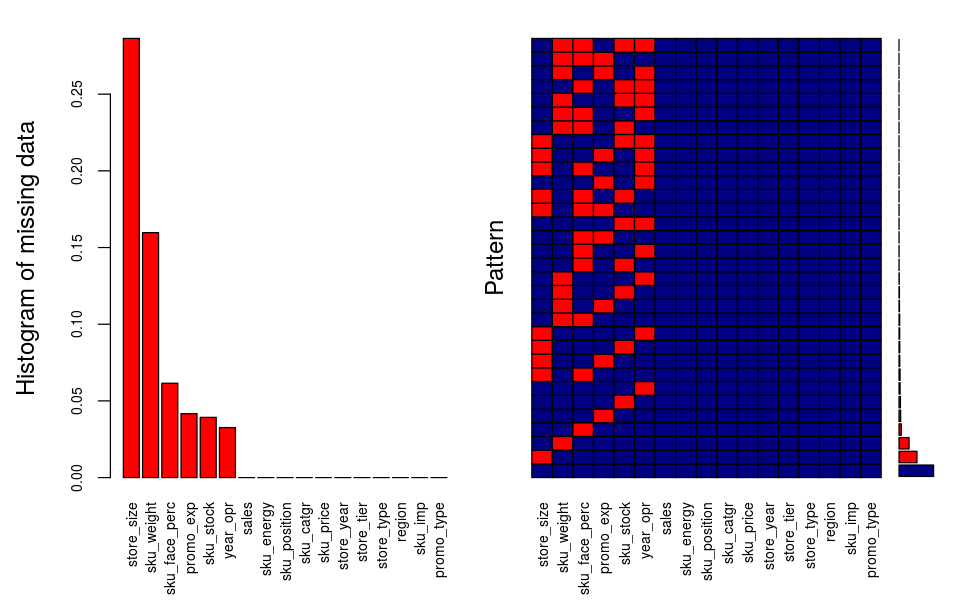

In [41]:
aggr(DB_F, col=c('navyblue','red'), numbers=TRUE, sortVars=TRUE, labels=names(DB_F), cex.axis=.7, gap=3, ylab=c("Histogram of missing data","Pattern"))

### Data Imputation
I’ve imputed missing values using Predictive mean matching.

In [42]:
completedData <- complete(mice(DB_F, m=3, maxit=5, meth='pmm', seed=5),1)


 iter imp variable
  1   1  sku_weight  sku_face_perc  year_opr  store_size  sku_stock  promo_exp
  1   2  sku_weight  sku_face_perc  year_opr  store_size  sku_stock  promo_exp
  1   3  sku_weight  sku_face_perc  year_opr  store_size  sku_stock  promo_exp
  2   1  sku_weight  sku_face_perc  year_opr  store_size  sku_stock  promo_exp
  2   2  sku_weight  sku_face_perc  year_opr  store_size  sku_stock  promo_exp
  2   3  sku_weight  sku_face_perc  year_opr  store_size  sku_stock  promo_exp
  3   1  sku_weight  sku_face_perc  year_opr  store_size  sku_stock  promo_exp
  3   2  sku_weight  sku_face_perc  year_opr  store_size  sku_stock  promo_exp
  3   3  sku_weight  sku_face_perc  year_opr  store_size  sku_stock  promo_exp
  4   1  sku_weight  sku_face_perc  year_opr  store_size  sku_stock  promo_exp
  4   2  sku_weight  sku_face_perc  year_opr  store_size  sku_stock  promo_exp
  4   3  sku_weight  sku_face_perc  year_opr  store_size  sku_stock  promo_exp
  5   1  sku_weight  sku_face_pe

# Feature Engineering

### Categorical to Numerical transformation

In [ ]:
completedData$sku_energy <- as.numeric(factor(completedData$sku_energy, levels = levels(completedData$sku_energy)))
completedData$sku_position <- as.numeric(factor(completedData$sku_position, levels = levels(completedData$sku_position)))
completedData$sku_catgr <- as.numeric(factor(completedData$sku_catgr, levels = levels(completedData$sku_catgr)))
completedData$store_size <- as.numeric(factor(completedData$store_size, levels = levels(completedData$store_size)))
completedData$store_tier <- as.numeric(factor(completedData$store_tier, levels = levels(completedData$store_tier)))
completedData$store_type <- as.numeric(factor(completedData$store_type, levels = levels(completedData$store_type)))
completedData$promo_type <- as.numeric(factor(completedData$promo_type, levels = levels(completedData$promo_type)))

### Recursive Feature Elemenations

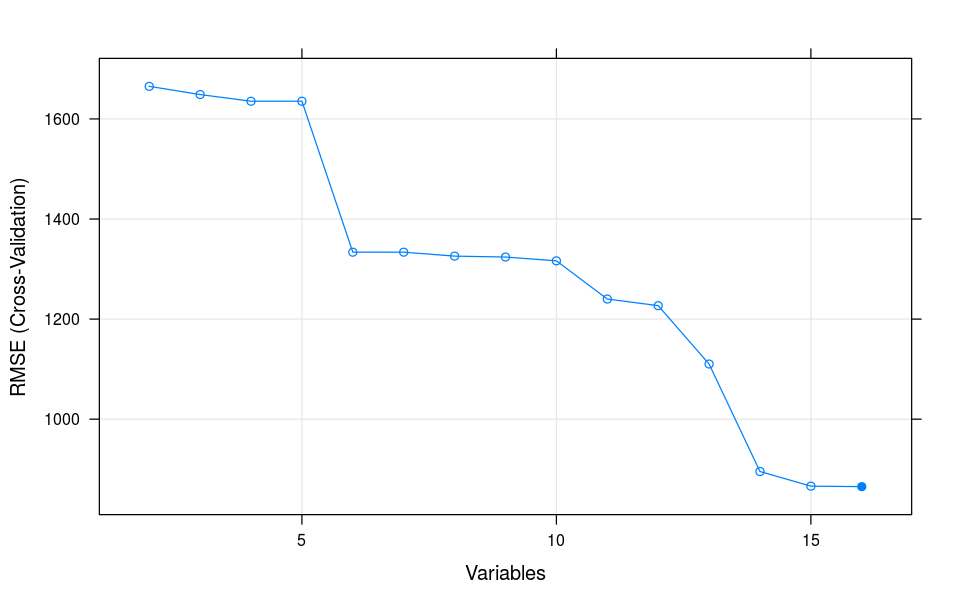

In [43]:
results <- rfe(completedData[,2:17], completedData[,1], size=c(2:17),rfeControl=rfeControl(functions=lmFuncs,method="cv", number=10))
plot(results, type=c("g", "o"))

### Redundant Feature Elimenations

In [44]:
highlyCorrelated <- findCorrelation(cor(completedData[,2:17]), cutoff=0.75)
dataset_features <- completedData[,-highlyCorrelated]

### Model Selection using 10-fold Cross Validations

In [45]:
set.seed(7)
control <- trainControl(method="repeatedcv", number=10, repeats=3)
metric <- "RMSE"
fit.lm <- train(sales~., data=dataset_features, method="lm", metric=metric, preProc=c("center", "scale"), trControl=control)
fit.glm <- train(sales~., data=dataset_features, method="glm", metric=metric, preProc=c("center", "scale"), trControl=control)
fit.glmnet <- train(sales~., data=dataset_features, method="glmnet", metric=metric, preProc=c("center", "scale"), trControl=control)
grid <- expand.grid(.cp=c(0, 0.05, 0.1))
fit.cart <- train(sales~., data=dataset_features, method="rpart", metric=metric, tuneGrid=grid, preProc=c("center", "scale"), trControl=control)
fit.knn <- train(sales~., data=dataset_features, method="knn", metric=metric, preProc=c("center", "scale"), trControl=control)

### Model Selection Summary
Classification and Regression Tree(CART) gives better RMSE than others algorithm.

In [46]:
results <- resamples(list(LM=fit.lm, GLM=fit.glm, GLMNET=fit.glmnet, CART=fit.cart, KNN=fit.knn))
summary(results)


Call:
summary.resamples(object = results)

Models: LM, GLM, GLMNET, CART, KNN 
Number of resamples: 30 

RMSE 
           Min.  1st Qu.   Median     Mean  3rd Qu.      Max. NA's
LM     782.7702 829.0909 845.9246 866.0790 864.1698 1087.3149    0
GLM    790.8090 830.6122 843.1939 865.5108 871.2277 1019.8552    0
GLMNET 804.1874 835.4778 846.3734 865.8633 862.6989 1007.2892    0
CART   551.0479 570.1621 582.2495 591.3253 605.3532  650.0747    0
KNN    727.0759 765.3136 781.5225 786.0064 808.6776  843.7789    0

Rsquared 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
LM     0.6158118 0.7347794 0.7521586 0.7358404 0.7559491 0.7618719    0
GLM    0.6571380 0.7401268 0.7475604 0.7356459 0.7538152 0.7651223    0
GLMNET 0.6587984 0.7398925 0.7454564 0.7357982 0.7517367 0.7653028    0
CART   0.8558421 0.8706053 0.8772211 0.8772727 0.8843857 0.8953071    0
KNN    0.7524484 0.7727203 0.7825921 0.7816788 0.7897799 0.8061114    0


### CART model Summary
We found CART RMSE **591.3253**

In [56]:
print(fit.cart)

CART 

14126 samples
   14 predictors

Pre-processing: centered (14), scaled (14) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 12712, 12713, 12714, 12713, 12714, 12714, ... 
Resampling results across tuning parameters:

  cp    RMSE       Rsquared 
  0.00   591.3253  0.8772727
  0.05   996.5150  0.6490902
  0.10  1254.9793  0.4432500

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was cp = 0.


### Model Selection Plot

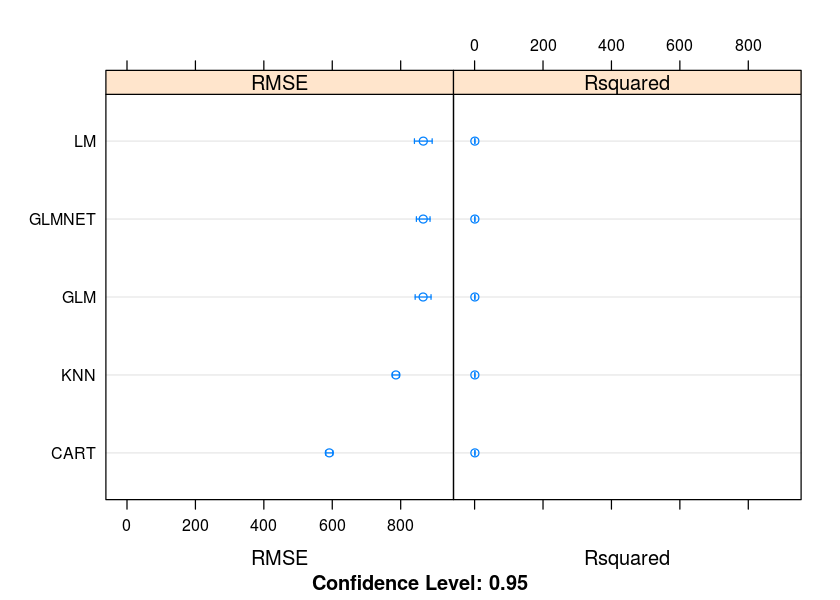

In [49]:
dotplot(results)

# Tune Algorithm
We can tune your machine learning algorithm parameters in R. Generally, the approaches in this section assume that we already have a shortlist of well performing machine learning algorithms for our problem from which we are looking to get better performance.

In [ ]:
control_tune <- trainControl(method="repeatedcv",number=2,repeats=1)
fit.rf <- train(sales~., data=dataset_features, method="rf", metric=metric, preProc=c("BoxCox"), trControl=control_tune, tuneLength=1)
fit.gbm <- train(sales~., data=dataset_features, method="gbm", metric=metric, preProc=c("BoxCox"), trControl=control_tune, verbose=FALSE)
fit.cubist <- train(sales~., data=dataset_features, method="cubist", metric=metric, preProc=c("BoxCox"), trControl=control_tune)

### Model Summary after Tuning
CUBIST improving model accuracy better than all other algorithms.

In [51]:
results_tune <- resamples(list(RF=fit.rf, GBM=fit.gbm, CUBIST=fit.cubist))
summary(results_tune)


Call:
summary.resamples(object = results_tune)

Models: RF, GBM, CUBIST 
Number of resamples: 2 

RMSE 
           Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
RF     576.8805 579.0623 581.2441 581.2441 583.4259 585.6077    0
GBM    593.1146 596.6660 600.2174 600.2174 603.7688 607.3202    0
CUBIST 512.1491 517.6737 523.1983 523.1983 528.7229 534.2475    0

Rsquared 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
RF     0.8835220 0.8840999 0.8846777 0.8846777 0.8852555 0.8858333    0
GBM    0.8714833 0.8721823 0.8728812 0.8728812 0.8735802 0.8742792    0
CUBIST 0.8992381 0.9012327 0.9032272 0.9032272 0.9052217 0.9072163    0


### CUBIST Summary
We can build our CUBIST model using commitees=20 and neighbours=9

In [55]:
print(fit.cubist)

Cubist 

14126 samples
   14 predictors

Pre-processing: Box-Cox transformation (12) 
Resampling: Cross-Validated (2 fold, repeated 1 times) 
Summary of sample sizes: 7063, 7063 
Resampling results across tuning parameters:

  committees  neighbors  RMSE      Rsquared 
   1          0          570.4154  0.8852720
   1          5          571.0337  0.8854919
   1          9          569.4188  0.8860589
  10          0          526.9490  0.9023909
  10          5          529.5459  0.9008762
  10          9          526.5146  0.9020002
  20          0          523.2309  0.9038823
  20          5          526.2935  0.9020781
  20          9          523.1983  0.9032272

RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were committees = 20 and neighbors = 9.


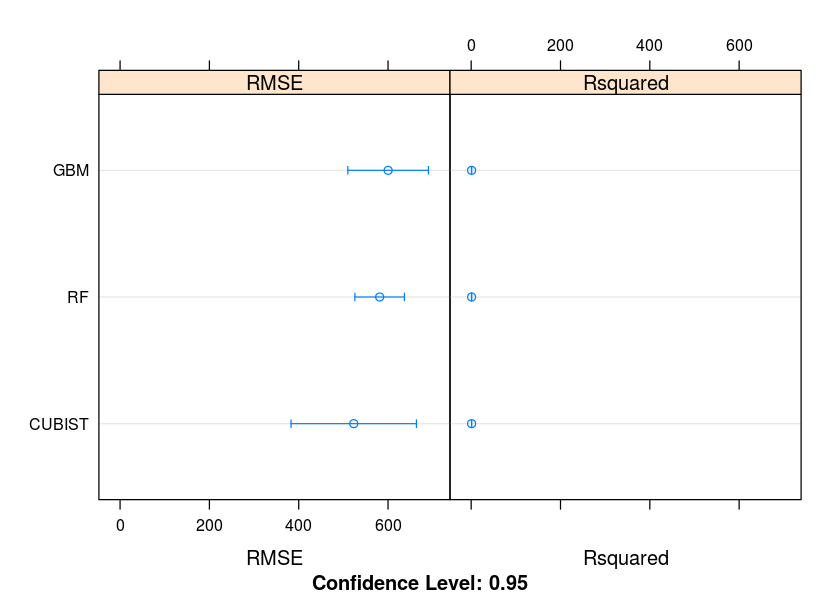

In [52]:
dotplot(results_tune)

### Lets try if we can improve CUBIST performance better than above using Grid Search

In [82]:
control_cubist <- trainControl(method="repeatedcv", number=2, repeats=1)
grid <- expand.grid(.committees=seq(15, 25, by=5), .neighbors=c(3, 5, 7, 9))
tune.cubist <- train(sales~., data=dataset_features, method="cubist", metric=metric, preProc=c("BoxCox"), tuneGrid=grid, tuneLength=1, trControl=control_cubist)

### CUBIST Summary

In [83]:
print(tune.cubist)

Cubist 

14126 samples
   14 predictors

Pre-processing: Box-Cox transformation (12) 
Resampling: Cross-Validated (2 fold, repeated 1 times) 
Summary of sample sizes: 7063, 7063 
Resampling results across tuning parameters:

  committees  neighbors  RMSE      Rsquared 
  15          3          536.1145  0.8983997
  15          5          531.6366  0.8999899
  15          7          527.7178  0.9014040
  15          9          525.6283  0.9021637
  20          3          536.8636  0.8981370
  20          5          532.3303  0.8997425
  20          7          528.4487  0.9011451
  20          9          526.3258  0.9019173
  25          3          539.4500  0.8971920
  25          5          534.7120  0.8988730
  25          7          530.6672  0.9003372
  25          9          528.4218  0.9011562

RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were committees = 15 and neighbors = 9.


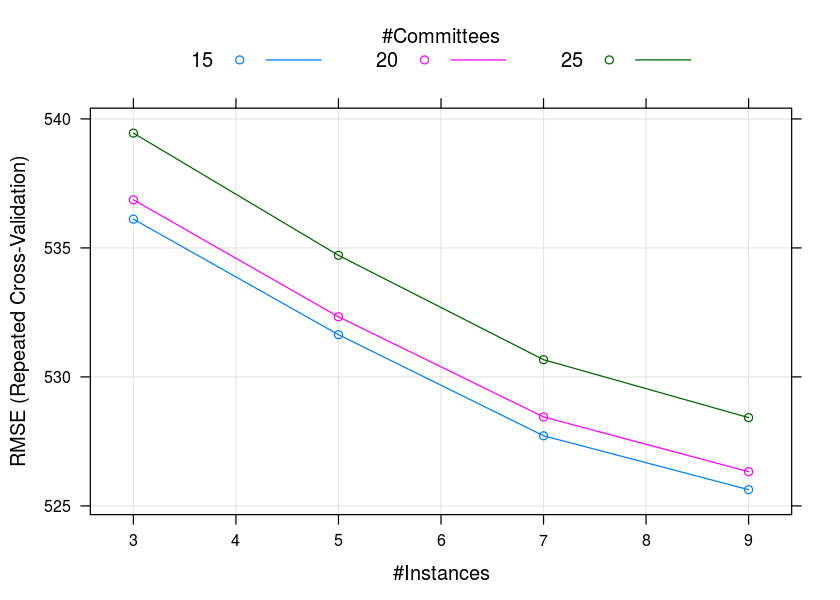

In [84]:
plot(tune.cubist)

# Final Model with CUBIST
Finally I build a model with CUBIST where I trained 80% randomly taken data to validate model accuracy for remaining 20% test data.

In [100]:
set.seed(6)
validation_index <- createDataPartition(completedData$sales, p=0.80, list=FALSE)
validation <- completedData[-validation_index,]
dataset <- completedData[validation_index,]
x <- dataset[,2:17]
y <- dataset[,1]
preprocessParams <- preProcess(x, method=c("BoxCox"))
trans_x <- predict(preprocessParams, x)
finalModel <- cubist(x=trans_x, y=y, committees=15)
val_x <- validation[,2:17]
trans_val_x <- predict(preprocessParams, val_x)
val_y <- validation[,1]
predictions <- predict(finalModel, newdata=trans_val_x, neighbors=9)

# Accuracy

### RMSE

In [103]:
rmse <- RMSE(predictions, val_y)
print(rmse)

[1] 474.9277


### R2

In [102]:
r2 <- R2(predictions, val_y)
print(r2)

[1] 0.9187921


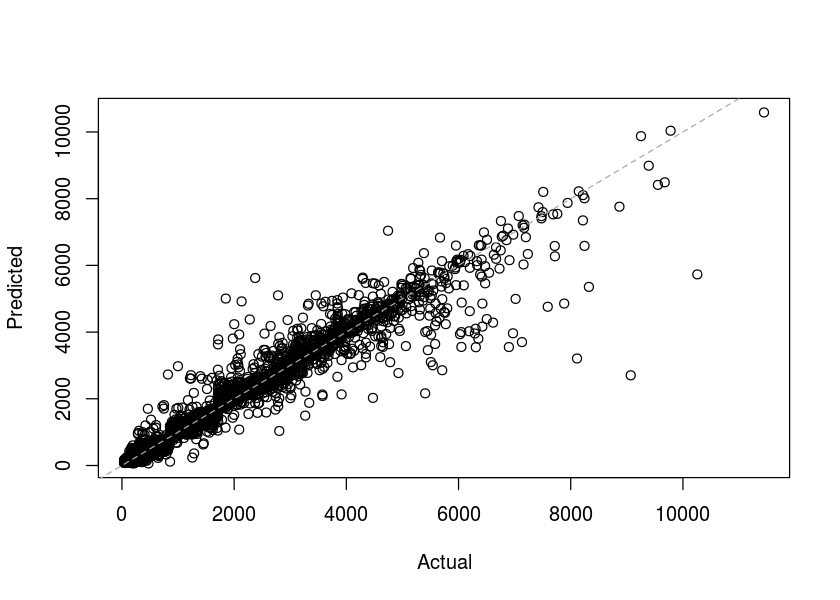

In [104]:
plot(val_y,predictions,xlab="Actual",ylab="Predicted")
abline(0,1,col="darkgrey",lty=2)